# ⚡️ EPEX Sport Data download and quick look
This Notebook was originally build in Google Colab

In [2]:
# GOOGLE COLAB: If you run this Notbook in Google Colab run the following command.
# OTHER: pip install this in your environment

!pip install entsoe-py pandas python-dateutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.8 MB/s eta 0:00:00


In [3]:
import os
from dateutil.relativedelta import relativedelta
from entsoe import EntsoePandasClient
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

In [4]:
# GOOGLE COLAB: If you run this Notbook in Google Colab run the following command.
# OTHER: Set your path normally

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# SET YOUR PATH HERE
notebook_path = 'SET YOUR PATH HERE'

# list files for quick check
files = os.listdir(notebook_path)
print("Files in folder:", files)

Files in folder: ['epex_AT_day_ahead_full.csv', 'epex_AT_day_ahead.csv', 'Fetch EPEX Spot prices history.ipynb']


## 📘 Fetch Austrian EPEX Spot day-ahead prices (last 2 years)

These are the one-time setup steps plus two Python cells you can run as-is.

---

### 1 Create an ENTSO-E Transparency Platform account  
1. Go to **https://transparency.entsoe.eu** → **Register**.  
2. Activate the account via the e-mail you receive.

### 2 Enable the Web-API  
Send an e-mail to **transparency@entsoe.eu** (subject “RESTful API access”) asking them to enable API access for your login.  
They usually reply within 1-3 working days.

### 3 Generate your security token  
After API access is switched on, open **My Account → Settings → Web-API security token → Generate new token**.  
Copy the 32-character token – you will need it below.


In [6]:
# GOOGLE COLAB: If you run this Notbook in Google Colab run the following command
#               AND SET YOUR API TOKEN IN COLABS SECRETS as 'EPEX_API_TOKEN'

from google.colab import userdata
TOKEN = userdata.get('EPEX_API_TOKEN')

# OTHER: SET YOUR TOKEN HERE
#TOKEN = "PUT YOUR TOKEN HERE"

In [7]:
# ------------------------------------------------------------------------------
# USE FUNCTION BELOW MOST OF THE TIME
# Fetch the last 2 years of data from today
# ------------------------------------------------------------------------------
csv_path = notebook_path + "/epex_AT_day_ahead.csv"
# -----------------

client = EntsoePandasClient(api_key=TOKEN)

utc_now = pd.Timestamp.utcnow().floor("h")
start   = utc_now - relativedelta(years=2)

series = client.query_day_ahead_prices(
    country_code="AT",             # Austria bidding zone
    start=start, end=utc_now
)

# convert from UTC to local Vienna time
series = series.tz_convert("Europe/Vienna")
series.to_csv(csv_path, header=["EUR_per_MWh"])

print(f"Saved {len(series):,} hourly rows to {csv_path}")

Saved 17,545 hourly rows to /content/drive/MyDrive/#powerhaus_ai/#Projekte/EPEX Spot Prices/epex_AT_day_ahead.csv


In [8]:
series.head()

,0
2023-06-21 16:00:00+02:00,99.98
2023-06-21 17:00:00+02:00,113.27
2023-06-21 18:00:00+02:00,137.87
2023-06-21 19:00:00+02:00,167.34
2023-06-21 20:00:00+02:00,190.00


In [9]:
# ------------------------------------------------------------------------------
# Fetch the data for number of years plus this year till today
# ------------------------------------------------------------------------------
csv_path = notebook_path +  "/epex_AT_day_ahead_full.csv"
country_code = "AT"
start_date = pd.Timestamp("2017-01-01", tz="UTC")
# -----------------

client = EntsoePandasClient(api_key=TOKEN)

# define end of last full calendar year
last_full_year_end = pd.Timestamp("2024-12-31T23:00", tz="UTC")

# define end of current request: day after today
utc_now = pd.Timestamp.utcnow().floor("h")
tomorrow = (utc_now + pd.Timedelta(days=1)).normalize()

# build a list of 1-year chunks
chunks = []
cursor = start_date

while cursor <= tomorrow:
    chunk_end = min(cursor + relativedelta(years=1), tomorrow + pd.Timedelta(hours=23))
    print(f"Fetching: {cursor.date()} → {chunk_end.date()}")
    try:
        chunk_series = client.query_day_ahead_prices(
            country_code=country_code,
            start=cursor, end=chunk_end
        )
        chunks.append(chunk_series)
    except Exception as e:
        print(f"⚠️ Failed for {cursor.date()} → {chunk_end.date()}: {e}")
    cursor = chunk_end + pd.Timedelta(hours=1)  # advance cursor to next hour

# combine and export
if chunks:
    series = pd.concat(chunks)
    series = series[~series.index.duplicated()]
    series = series.tz_convert("Europe/Vienna")
    series.to_csv(csv_path, header=["EUR_per_MWh"])
    print(f"✅ Saved {len(series):,} hourly rows to {csv_path}")
else:
    print("❌ No data downloaded.")

Fetching: 2017-01-01 → 2018-01-01


⚠️ Failed for 2017-01-01 → 2018-01-01: 
Fetching: 2018-01-01 → 2019-01-01
Fetching: 2019-01-01 → 2020-01-01
Fetching: 2020-01-01 → 2021-01-01
Fetching: 2021-01-01 → 2022-01-01
Fetching: 2022-01-01 → 2023-01-01
Fetching: 2023-01-01 → 2024-01-01
Fetching: 2024-01-01 → 2025-01-01
Fetching: 2025-01-01 → 2025-06-22
✅ Saved 56,780 hourly rows to /content/drive/MyDrive/#powerhaus_ai/#Projekte/EPEX Spot Prices/epex_AT_day_ahead_full.csv


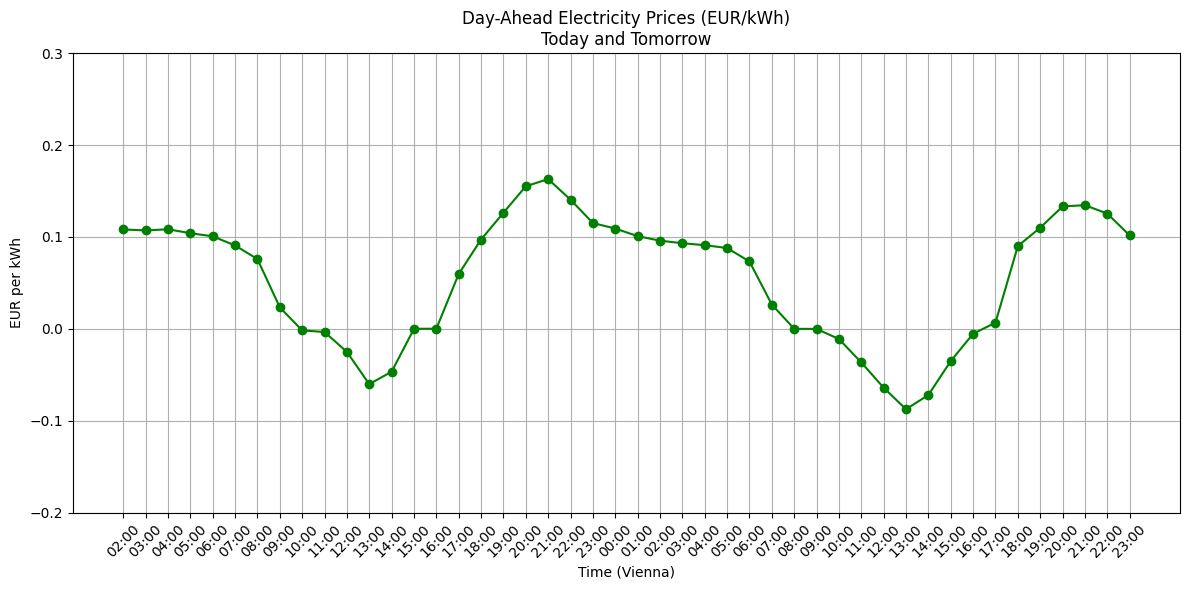

In [10]:
# ------------------------------------------------------------------------------
# Fetch the data of today and tomorrow and plot it directly for a quick look
# ------------------------------------------------------------------------------

client = EntsoePandasClient(api_key=TOKEN)

# Get today's and tomorrow's date range in UTC
utc_now = pd.Timestamp.utcnow().normalize()
start = utc_now
end = utc_now + pd.Timedelta(days=2)

# Query day-ahead prices for Austria (AT)
series = client.query_day_ahead_prices(
    country_code="AT",
    start=start,
    end=end
)

# Convert to local timezone (Vienna)
series = series.tz_convert("Europe/Vienna")

# Convert to DataFrame and rename column
df_today_tomorrow = series.to_frame(name="EUR_per_MWh")
df_today_tomorrow["EUR_per_kWh"] = df_today_tomorrow["EUR_per_MWh"] / 1000

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_today_tomorrow.index, df_today_tomorrow["EUR_per_kWh"], marker='o', linestyle='-', color='green')
plt.title("Day-Ahead Electricity Prices (EUR/kWh)\nToday and Tomorrow")
# Format x-axis to show every hour in HH:00 format
plt.xticks(df_today_tomorrow.index, df_today_tomorrow.index.strftime('%H:00'), rotation=45)
plt.xlabel("Time (Vienna)")
plt.ylabel("EUR per kWh")
plt.ylim(bottom=-0.2, top=0.3)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

---

## 📌 Notes

- 🌍 **Time zone**: Prices are returned in **UTC** by the API but automatically converted to **Europe/Vienna** local time (with DST handled).
- 💶 **Unit**: Prices are in **EUR per MWh** (`EUR/MWh`).
- ⚠️ **Request limit**: The ENTSO-E API only allows **1 year per request** for day-ahead prices.
- ⛔ **Rate limit**: ENTSO-E allows up to **60 requests per minute** and **10 kB/s** bandwidth. This script stays well under that limit.
- 🛡️ **Security token**: Keep your token private. It does not expire unless revoked, but don’t commit it to public code.
- 📁 **Output file**: The CSV file contains 17,520 rows (2 years × 365 days × 24 hours) (for the 2 year data fetching), with:
  - **Datetime index** in Vienna local time
  - **Price values** under the column `EUR_per_MWh`

---

## 📎 Resources

- ENTSO-E Transparency Platform: [https://transparency.entsoe.eu](https://transparency.entsoe.eu)
- API documentation: [https://transparency.entsoe.eu/content/static_content/Static%20content/web%20api/Guide.html](https://transparency.entsoe.eu/content/static_content/Static%20content/web%20api/Guide.html)
- ENTSOE-PY GitHub: [https://github.com/EnergieID/entsoe-py](https://github.com/EnergieID/entsoe-py)

---

## 📊 Get the Data from the CSV

In [11]:
csv_path = notebook_path +  "/epex_AT_day_ahead_full.csv"
df_data = pd.read_csv(csv_path, names=['time', 'EUR_per_MWh'], header=0)
df_data.reset_index(drop=True, inplace=True)
display(df_data.head())

,time,EUR_per_MWh
0,2018-12-31 03:00:00+01:00,45.89
1,2018-12-31 04:00:00+01:00,45.47
2,2018-12-31 05:00:00+01:00,47.11
3,2018-12-31 06:00:00+01:00,49.12
4,2018-12-31 07:00:00+01:00,53.79


In [12]:
# The df_data variable is already a DataFrame, so we can directly add the new column
df_data = pd.read_csv(csv_path, names=['time', 'EUR_per_MWh'], header=0, index_col=False)
df_data['EUR_per_kWh'] = df_data['EUR_per_MWh'] / 1000
df_data

,time,EUR_per_MWh,EUR_per_kWh
0,2018-12-31 03:00:00+01:00,45.89,0.04589
1,2018-12-31 04:00:00+01:00,45.47,0.04547
2,2018-12-31 05:00:00+01:00,47.11,0.04711
3,2018-12-31 06:00:00+01:00,49.12,0.04912
4,2018-12-31 07:00:00+01:00,53.79,0.05379
...,...,...,...
56775,2025-06-22 19:00:00+02:00,110.06,0.11006
56776,2025-06-22 20:00:00+02:00,133.19,0.13319
56777,2025-06-22 21:00:00+02:00,134.56,0.13456
56778,2025-06-22 22:00:00+02:00,125.38,0.12538


## 🩻 Checking out the Data

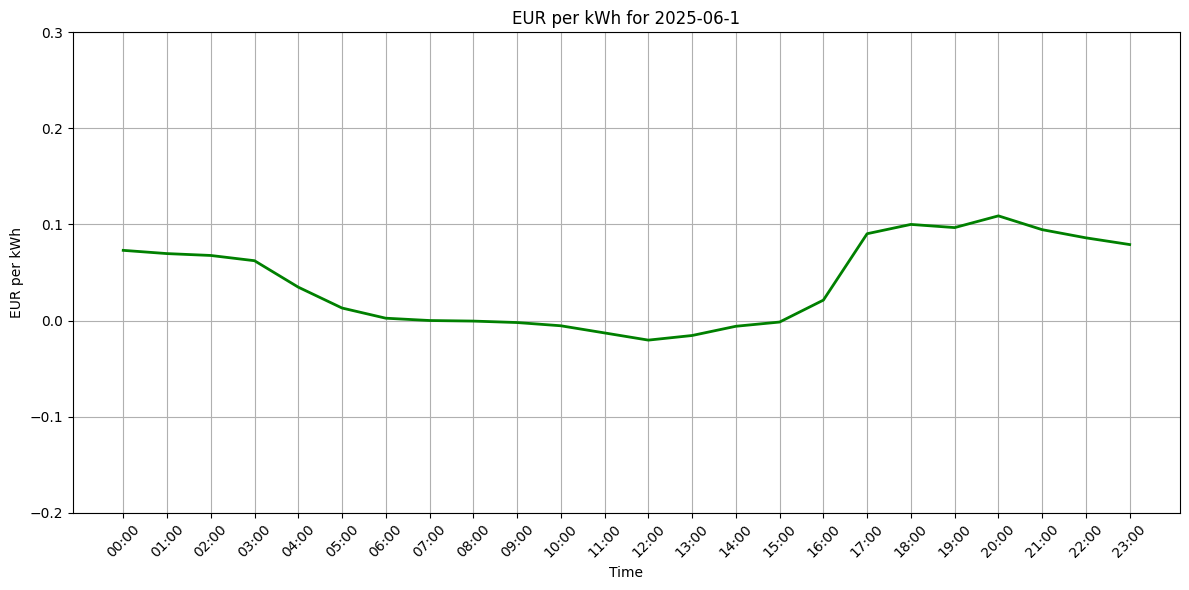

In [14]:
# ------------------------------------------------------------------------------
# Plot EUR per kWh for one day
# ------------------------------------------------------------------------------
# Change this date to plot a different day
selected_date = '2025-06-1'
# -----------------

# Ensure 'time' is datetime and keep a clean index
df_data['time'] = pd.to_datetime(df_data['time'], utc=True)
df_data = df_data.reset_index(drop=True)

# Filter the DataFrame for the selected date using the 'time' column
df_one_day = df_data[df_data['time'].dt.date == pd.to_datetime(selected_date).date()]

# Plot the EUR_per_kWh for the selected day
plt.figure(figsize=(12, 6))
plt.plot(df_one_day['time'], df_one_day['EUR_per_kWh'], linewidth=2, color='green')
plt.title(f'EUR per kWh for {selected_date}')
plt.xlabel('Time')
plt.ylabel('EUR per kWh')

# Set x-axis ticks to every hour and format labels
plt.xticks(
    df_one_day['time'],
    df_one_day['time'].dt.strftime('%H:%M'),
    rotation=45
)

# Set y-axis - adjust as needed
plt.ylim(bottom=-0.2, top=0.3)

plt.grid(True)
plt.tight_layout()
plt.show()

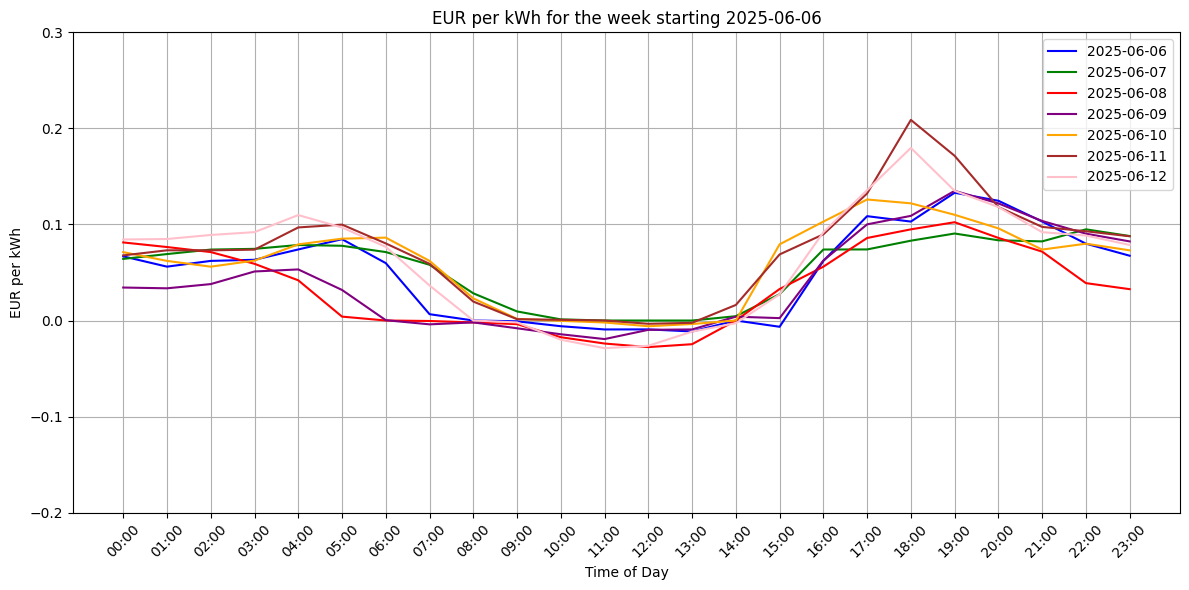

In [15]:
# ------------------------------------------------------------------------------
# Plot EUR per kWh for every day of one week
# ------------------------------------------------------------------------------
# Change this to the Monday of the week you want to plot
start_date = '2025-06-06'
# -----------------

# Ensure 'time' is a datetime column
df_data['time'] = pd.to_datetime(df_data['time'], utc=True)
df_data = df_data.reset_index(drop=True)  # Ensure clean index

# Define a list of colors for each day
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

plt.figure(figsize=(12, 6))

# Iterate through the days of the week
for i in range(7):
    current_date = pd.to_datetime(start_date) + relativedelta(days=i)
    df_one_day = df_data[df_data['time'].dt.date == current_date.date()]

    # Plot the EUR_per_kWh for the current day
    plt.plot(
        df_one_day['time'].dt.strftime('%H:%M'),
        df_one_day['EUR_per_kWh'],
        color=colors[i],
        label=current_date.strftime('%Y-%m-%d')
    )

plt.title(f'EUR per kWh for the week starting {start_date}')
plt.xlabel('Time of Day')
plt.ylabel('EUR per kWh')
plt.xticks(rotation=45)
plt.ylim(bottom=-0.2, top=0.3)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

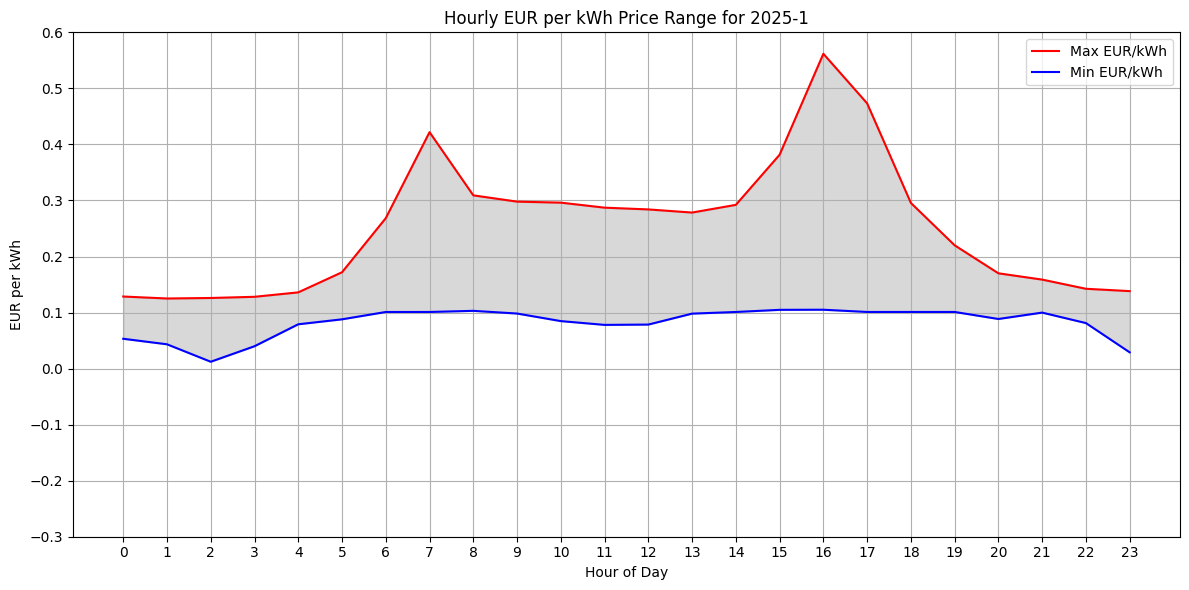

In [16]:
# ------------------------------------------------------------------------------
# Plot EUR per kWh for one month (shows span of min and max prices)
# ------------------------------------------------------------------------------
# Change this to the month you want to plot (YYYY-MM)
selected_month = '2025-1'
# -----------------

# Ensure 'time' column is datetime
df_data['time'] = pd.to_datetime(df_data['time'], utc=True)
df_data = df_data.reset_index(drop=True)  # Clean index

selected_period = pd.Period(selected_month, freq='M')

# Strip timezone before comparison to avoid warning
df_one_month = df_data[df_data['time'].dt.tz_localize(None).dt.to_period('M') == selected_period]

# Group by hour and calculate min/max
hourly_range = df_one_month.groupby(df_one_month['time'].dt.hour)['EUR_per_kWh'].agg(['min', 'max'])

# Plot the price range
plt.figure(figsize=(12, 6))
plt.plot(hourly_range.index, hourly_range['max'], label='Max EUR/kWh', color='red')
plt.plot(hourly_range.index, hourly_range['min'], label='Min EUR/kWh', color='blue')
plt.fill_between(hourly_range.index, hourly_range['min'], hourly_range['max'], color='gray', alpha=0.3)

plt.title(f'Hourly EUR per kWh Price Range for {selected_month}')
plt.xlabel('Hour of Day')
plt.ylabel('EUR per kWh')
plt.xticks(hourly_range.index)
plt.ylim(bottom=-0.3, top=0.6)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

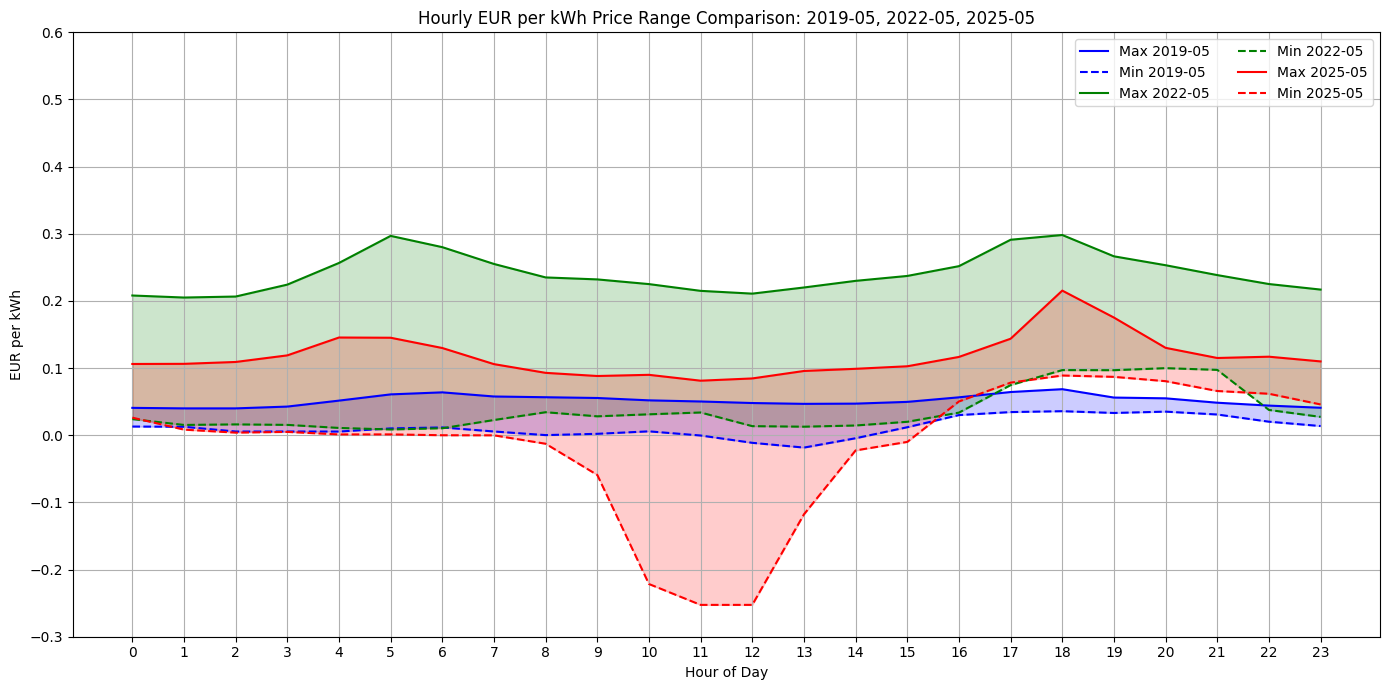

In [17]:
# ------------------------------------------------------------------------------
# Plot EUR per kWh for several months (shows span of min and max prices per month)
# ------------------------------------------------------------------------------
# Change this to the months you want to plot
#selected_months = ['2019-05', '2020-05', '2021-05', '2022-05', '2023-05', '2024-05', '2025-05']
selected_months = ['2019-05', '2022-05', '2025-05']
# -----------------

# Ensure 'time' column is datetime and reset index
df_data['time'] = pd.to_datetime(df_data['time'], utc=True)
df_data = df_data.reset_index(drop=True)

# Define a color palette (extendable if needed)
color_palette = [
    'blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink',
    'teal', 'gray', 'olive'  # extend here if needed
]

plt.figure(figsize=(14, 7))

# Plot each month's data
for i, selected_month in enumerate(selected_months):
    if i >= len(color_palette):
        print(f"Warning: Not enough colors defined for month {selected_month}, skipping.")
        continue

    selected_period = pd.Period(selected_month, freq='M')

    # Filter data for the selected month (strip timezone to avoid warning)
    df_one_month = df_data[df_data['time'].dt.tz_localize(None).dt.to_period('M') == selected_period]

    if df_one_month.empty:
        print(f"No data for {selected_month}, skipping.")
        continue

    # Group by hour and calculate min/max
    hourly_range = df_one_month.groupby(df_one_month['time'].dt.hour)['EUR_per_kWh'].agg(['min', 'max'])

    # Plot with distinct color
    plt.plot(hourly_range.index, hourly_range['max'], label=f'Max {selected_month}', color=color_palette[i], linestyle='-')
    plt.plot(hourly_range.index, hourly_range['min'], label=f'Min {selected_month}', color=color_palette[i], linestyle='--')
    plt.fill_between(hourly_range.index, hourly_range['min'], hourly_range['max'], color=color_palette[i], alpha=0.2)

# Finalize the plot
plt.title(f'Hourly EUR per kWh Price Range Comparison: {", ".join(selected_months)}')
plt.xlabel('Hour of Day')
plt.ylabel('EUR per kWh')
plt.xticks(range(24))
plt.ylim(bottom=-0.3, top=0.6)
plt.grid(True)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

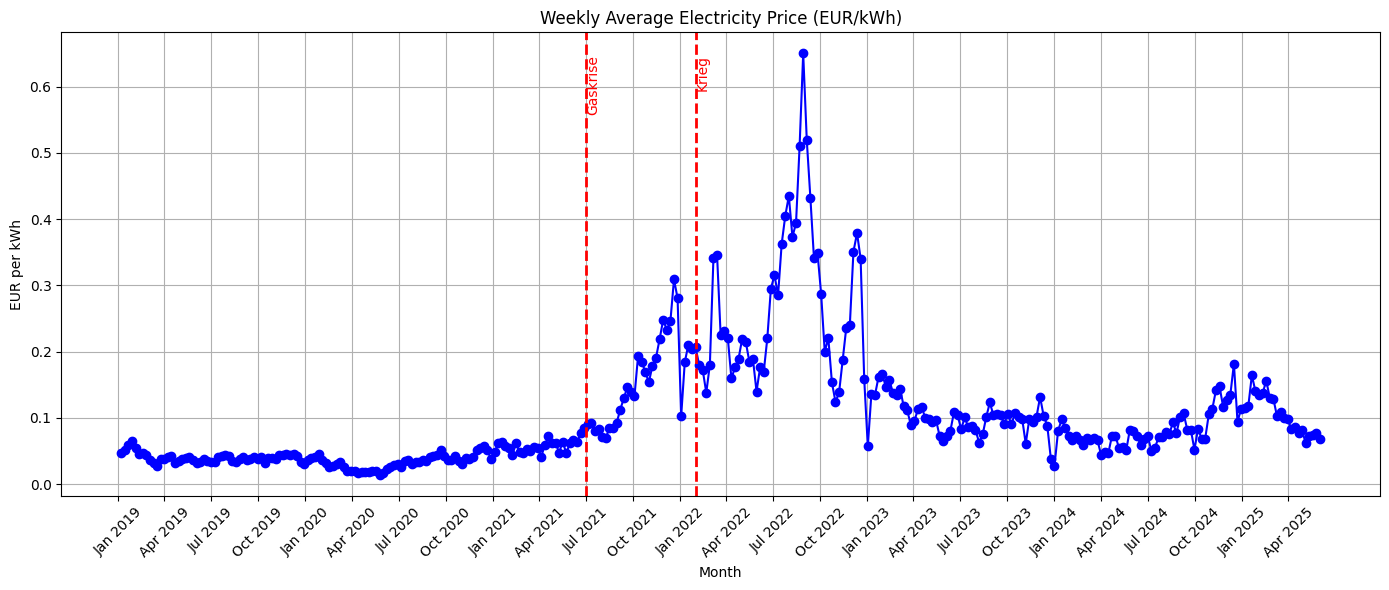

In [18]:
# ------------------------------------------------------------------------------
# Plot the weekly average electricity price
# ------------------------------------------------------------------------------
# Change this to the span you want to see
start_date = "2019-01-01"
end_date   = "2025-06-01"
# -----------------

# Ensure 'time' column is datetime
df_data['time'] = pd.to_datetime(df_data['time'], utc=True)
df_data = df_data.reset_index(drop=True)

# Strip timezone for grouping/resampling
df_data['time_local'] = df_data['time'].dt.tz_localize(None)

# Filter by date range
mask = (df_data['time_local'] >= pd.to_datetime(start_date)) & (df_data['time_local'] <= pd.to_datetime(end_date))
df_filtered = df_data.loc[mask]

# Set datetime index for resampling
df_filtered = df_filtered.set_index('time_local')

# Resample by week starting on Monday, calculate weekly average
weekly_avg = df_filtered['EUR_per_kWh'].resample('W-MON').mean()

# --- Prepare x-axis ticks: every 3rd month -----------------------------------
month_starts = weekly_avg.index.to_period("M").drop_duplicates().to_timestamp()
every_third_month = month_starts[::3]

# --- Plot ---------------------------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(weekly_avg.index, weekly_avg.values, marker='o', linestyle='-', color='blue')

# Add red vertical line at February 2022 for "Gaskrise" and "Krieg"
gaskrise_date = pd.Timestamp("2022-02-01")
plt.axvline(gaskrise_date, color='red', linestyle='--', linewidth=2)
plt.text(gaskrise_date, plt.ylim()[1]*0.95, 'Krieg', color='red', rotation=90, verticalalignment='top', fontsize=10)

gaskrise_date = pd.Timestamp("2021-07-01")
plt.axvline(gaskrise_date, color='red', linestyle='--', linewidth=2)
plt.text(gaskrise_date, plt.ylim()[1]*0.95, 'Gaskrise', color='red', rotation=90, verticalalignment='top', fontsize=10)

# Set custom x-ticks (every 3rd month)
plt.xticks(
    ticks=every_third_month,
    labels=every_third_month.strftime('%b %Y'),
    rotation=45
)

plt.title("Weekly Average Electricity Price (EUR/kWh)")
plt.xlabel("Month")
plt.ylabel("EUR per kWh")
plt.grid(True)
plt.tight_layout()
plt.show()

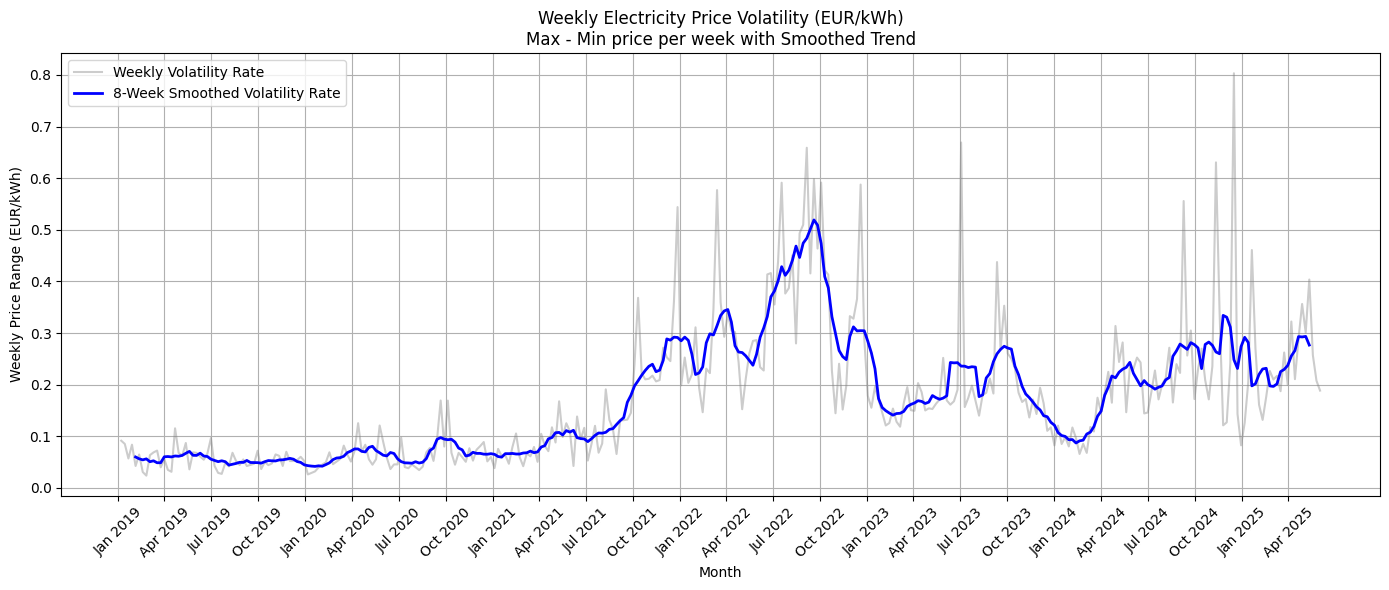

In [19]:
# ------------------------------------------------------------------------------
# Plots the volatility of Energy prices per week and smooths them for better readability
# ------------------------------------------------------------------------------
# Change this to the span you want to see
start_date = "2019-01-01"
end_date   = "2025-06-01"
rolling_window = 8  # weeks for smoothing
# -----------------

# Ensure 'time' column is datetime
df_data['time'] = pd.to_datetime(df_data['time'], utc=True)
df_data = df_data.reset_index(drop=True)

# Strip timezone for grouping/resampling
df_data['time_local'] = df_data['time'].dt.tz_localize(None)

# Filter by date range
mask = (df_data['time_local'] >= pd.to_datetime(start_date)) & (df_data['time_local'] <= pd.to_datetime(end_date))
df_filtered = df_data.loc[mask].set_index('time_local')

# --- Calculate weekly volatility ----------------------------------------------
weekly_volatility = df_filtered['EUR_per_kWh'].resample('W-MON').agg(lambda x: x.max() - x.min())
weekly_smoothed = weekly_volatility.rolling(window=rolling_window, center=True).mean()

# --- Prepare x-axis ticks (every 3rd month) -----------------------------------
month_starts = weekly_volatility.index.to_period("M").drop_duplicates().to_timestamp()
every_third_month = month_starts[::3]

# --- Plot ---------------------------------------------------------------------
plt.figure(figsize=(14, 6))

# Plot original values in lighter color
plt.plot(weekly_volatility.index, weekly_volatility.values, color='grey', alpha=0.4, linestyle='-', label='Weekly Volatility Rate')

# Plot smoothed line
plt.plot(weekly_smoothed.index, weekly_smoothed.values, color='blue', linewidth=2, label=f'{rolling_window}-Week Smoothed Volatility Rate')

# Set custom x-ticks (every 3rd month)
plt.xticks(
    ticks=every_third_month,
    labels=every_third_month.strftime('%b %Y'),
    rotation=45
)

plt.title("Weekly Electricity Price Volatility (EUR/kWh)\nMax - Min price per week with Smoothed Trend")
plt.xlabel("Month")
plt.ylabel("Weekly Price Range (EUR/kWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

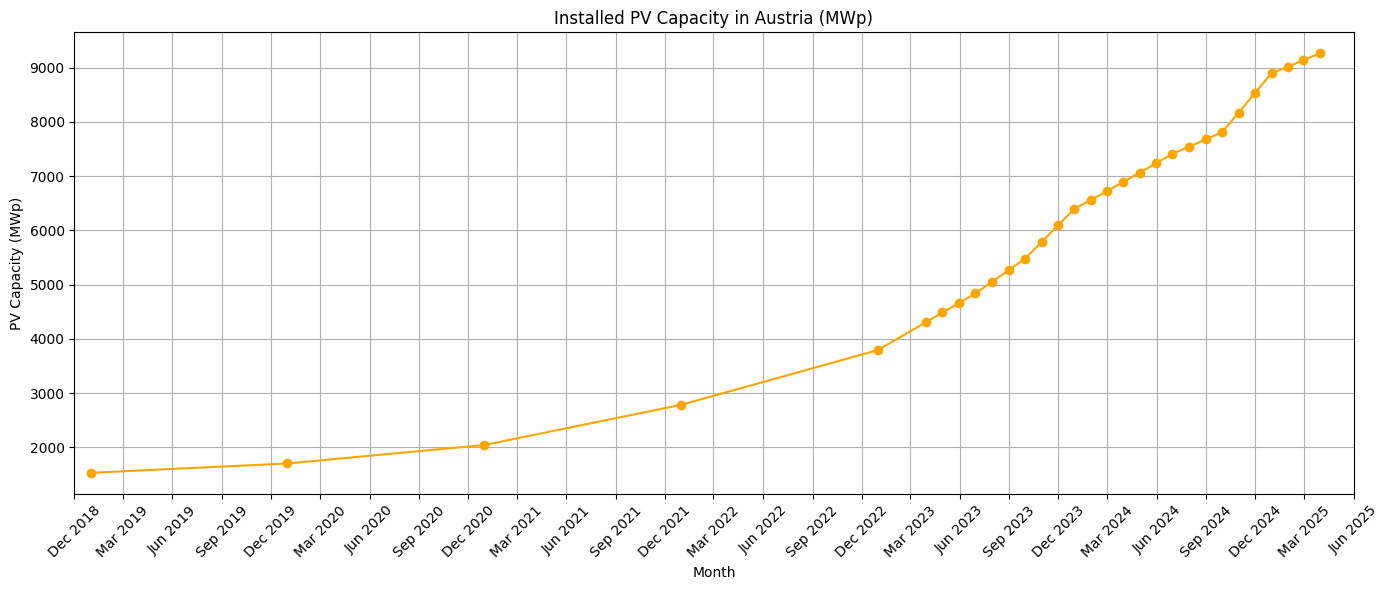

In [20]:
# ------------------------------------------------------------------------------
# Has the approximate pv capacity data for austria and plots it over time
# ------------------------------------------------------------------------------

# PV Capacity Data
AT_pv_data = {
    "date": [
        "2018-12-31", "2019-12-31", "2020-12-31", "2021-12-31", "2022-12-31",
        "2023-03-31", "2023-04-30", "2023-05-31", "2023-06-30",
        "2023-07-31", "2023-08-31", "2023-09-30",
        "2023-10-31", "2023-11-30", "2023-12-31",
        "2024-01-31", "2024-02-29", "2024-03-31",
        "2024-04-30", "2024-05-31", "2024-06-30",
        "2024-07-31", "2024-08-31", "2024-09-30",
        "2024-10-31", "2024-11-30", "2024-12-31",
        "2025-01-31", "2025-02-28", "2025-03-31"
    ],
    "pv_capacity_mwp": [
        1530, 1702, 2043, 2783, 3792,
        4309, 4485, 4660, 4836,
        5049, 5263, 5476,
        5782, 6089, 6395,
        6561, 6719, 6892,
        7064, 7237, 7409,
        7542, 7675, 7808,
        8170, 8533, 8895,
        9017, 9140, 9262
    ]
}

# Convert to DataFrame
df_pv = pd.DataFrame(AT_pv_data)
df_pv["date"] = pd.to_datetime(df_pv["date"])

# Plot PV Capacity over Time
plt.figure(figsize=(14, 6))
plt.plot(df_pv["date"], df_pv["pv_capacity_mwp"], marker='o', linestyle='-', color='orange')

plt.title("Installed PV Capacity in Austria (MWp)")
plt.xlabel("Month")
plt.ylabel("PV Capacity (MWp)")
plt.grid(True)

# Match x-axis range with previous volatility plot
plt.xlim(pd.Timestamp("2018-12-01"), pd.Timestamp("2025-06-01"))

# Format x-ticks every 3 months like previous plot
month_starts = pd.date_range(start="2018-12-01", end="2025-06-01", freq="MS")
every_third_month = month_starts[::3]
plt.xticks(every_third_month, every_third_month.strftime('%b %Y'), rotation=45)

plt.tight_layout()
plt.show()

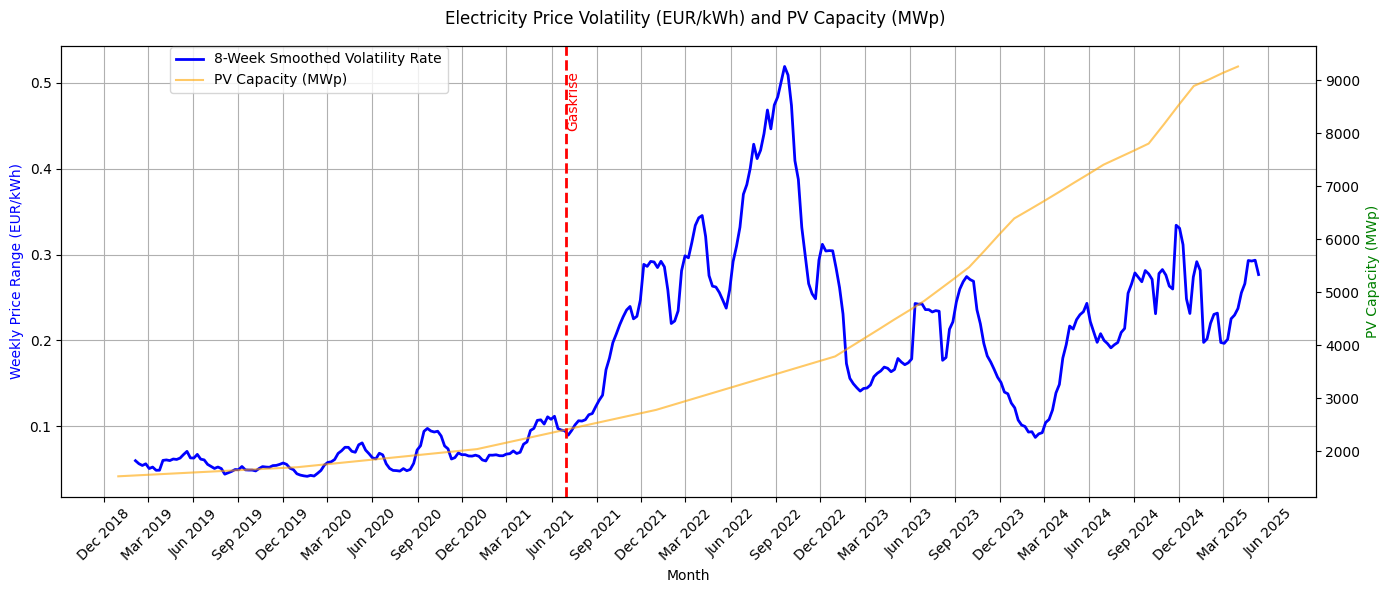

In [21]:
# ------------------------------------------------------------------------------
# Plots the Electric Price Volatility over the PV Capacity
# ------------------------------------------------------------------------------

df_pv["date"] = pd.to_datetime(df_pv["date"])

# --- Weekly Volatility Calculation (assumes df_filtered is ready) ------------
weekly_volatility = df_filtered['EUR_per_kWh'].resample('W-MON').agg(lambda x: x.max() - x.min())
weekly_smoothed = weekly_volatility.rolling(window=8, center=True).mean()

# --- Plot ---------------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot weekly volatility (raw and smoothed)
#ax1.plot(weekly_volatility.index, weekly_volatility.values, color='orange', alpha=0.3, label='Weekly Range')
ax1.plot(weekly_smoothed.index, weekly_smoothed.values, color='blue', linewidth=2, label='8-Week Smoothed Volatility Rate')
ax1.set_ylabel("Weekly Price Range (EUR/kWh)", color='blue')
ax1.set_xlabel("Month")

# x-ticks: every 3rd month
month_starts = pd.date_range(start="2018-12-01", end="2025-06-01", freq="MS")
every_third_month = month_starts[::3]
ax1.set_xticks(every_third_month)
ax1.set_xticklabels(every_third_month.strftime('%b %Y'), rotation=45)

# Secondary y-axis for PV capacity
ax2 = ax1.twinx()
ax2.plot(df_pv["date"], df_pv["pv_capacity_mwp"], color='orange', linestyle='-', label='PV Capacity (MWp)', alpha=0.6)
ax2.set_ylabel("PV Capacity (MWp)", color='green')

gaskrise_date = pd.Timestamp("2021-07-01")
plt.axvline(gaskrise_date, color='red', linestyle='--', linewidth=2)
plt.text(gaskrise_date, plt.ylim()[1]*0.95, 'Gaskrise', color='red', rotation=90, verticalalignment='top', fontsize=10)

# Grid and layout
ax1.grid(True)
fig.suptitle("Electricity Price Volatility (EUR/kWh) and PV Capacity (MWp)")
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.93))

plt.show()